<a href="https://colab.research.google.com/github/amalbumbia/HofstaderButterflies/blob/main/Square_Lattice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from math import gcd

The following class provides supports for simulating Anderson localization and the Hofstader model on a finite square lattice with periodic boundary conditions. The possible outputs are a plot of the eigenvalue spectrum, an eigenvector from the middle of the spectrum, the participation ratio, and the Hofstader butterfly.

A feature of this code is the lack of dependence on crystal momentum.

The $\phi$ parameter allows you to impose a magnetic field onto the hamiltonian and see its impact on the eigenvalues, eigenvectors, and participation ratio.

Note that the butterfly construction depends on the $q$ parameter and NOT phi. This is because there are certain allowed coprime integer pairs $(p,q)$ that can define $\phi$, and we can set a maximum value for $q$. Then, the butterfly will be generated over all possible allowed $p/q$ ratios up to the maximum allowed $q$ set by the user.

An interesting result to note is that the presence of disorder (it doesn't matter what the physical cause of it may be) kills the butterfly fractal. This idea is discussed in https://journals.aps.org/prb/abstract/10.1103/PhysRevB.71.125310 and https://link.springer.com/chapter/10.1007/978-3-030-21511-8_5 .


In [ ]:
class Square_Hamiltonian:
    """ Square lattice hamiltonian class """
    def __init__(self, length: int, t: float, disorder: float, phi: float, q: int):
        self.L = length  # set hamiltonian dimensions
        self.matrix = np.zeros((self.L * self.L, self.L * self.L), dtype=complex)  # initialize hamiltonian matrix
        self.disorder = disorder  # set disorder parameter
        self.t = t
        self.phi = phi
        self.max_q = q  # Set a maximum denominator for phi values

    def disorder_setter(self, i):
        # incorporate the disorder parameter into matrix elements
        eps_i = self.disorder * (2 * np.random.rand() - 1)  # random on-site energy
        self.matrix[i, i] = eps_i

    def hamiltonian_setter(self, i, j, phi=None):
        n = i * self.L + j
        # Vertical hopping
        m = ((i + 1) % self.L) * self.L + j
        self.matrix[n, m] = self.t

        # Horizontal hopping
        m = i * self.L + (j + 1) % self.L

        B = np.exp(1j * 2 * np.pi * (self.phi if phi is None else phi) * i)
        self.matrix[n, m] = B * self.t

        if self.disorder != 0:
            self.disorder_setter(n)


    def construct_matrix(self, phi=None):
        # we want to iterate through i and j
        for i, j in np.ndindex((self.L, self.L)):
            self.hamiltonian_setter(i, j, phi)

        if self.phi != 0:
            self.H = (self.matrix + self.matrix.T.conj()) / 2 # symmetrize
        else:
            self.H = self.matrix + self.matrix.T  # symmetrize
        self.evals, self.evecs = np.linalg.eigh(self.H)  # calculate eigenvalues and eigenvectors

    """ basic plotting functions """

    def plot_evals(self):
        # plot eigenvalues of hamiltonian matrix
        plt.plot(self.evals, '.')
        plt.ylabel(r'$E_i$')
        plt.xlabel(r'$i$')
        plt.show()

    def plot_evec(self):
        # plot an eigenvector
        self.psi = self.evecs[:,self.L//2] # some eigenvector in the middle of the spectrum
        plt.plot(np.abs(self.psi)**2)
        plt.xlabel('x')
        plt.ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_evec_disorder(self):
        self.psi = self.evecs[:,self.L//2] # some eigenvector in the middle of the spectrum
        fig, ax = plt.subplots(2,1,sharex=True)
        ax[0].plot(np.abs(self.psi)**2)
        ax[1].semilogy(np.abs(self.psi)**2)
        ax[1].set_xlabel('x')
        ax[0].set_ylabel(r'$ |\psi(x)|^2$')
        ax[1].set_ylabel(r'$ |\psi(x)|^2$')
        plt.show()

    def plot_pr(self):
        self.PR = 1./np.sum(np.abs(self.evecs)**4, axis=0) # 'evecs' is a matrix of $\psi_i(x)$ amplitudes, 1st axis is x. This does the sum over x.
        plt.plot(self.evals, self.PR, 'o')
        plt.xlabel('E')
        plt.ylabel('PR(E)')
        plt.show()

    """ hofstader butterfly support """
    # Plot the Hofstadter butterfly

    def plot_butterfly(self):
        plt.figure(figsize=(8, 6))
        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
              if q > p and gcd(p, q) == 1:
                  nphi = p / q
                  self.construct_matrix(phi = nphi) # rebuild hamiltonian for each (p,q)
                  # Plot each energy level for the given phi
                  plt.plot(self.evals, np.full_like(self.evals, nphi), 'o', c="black", markersize=0.1)

        # Plot title and labels
        plt.xlabel(r'$E$', fontsize=15)
        plt.ylabel(r'$\phi$', fontsize=15)
        plt.title(r'Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$' , fontsize=15)
        plt.grid()
        plt.show()

      """ density of states """

    def gaussian_broadening(self, E, E_n, sigma):
        return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((E - E_n) ** 2) / (2 * sigma ** 2))

    # compute DOS
    def density_of_states(self):
        energy_range = (np.min(self.evals) - 1, np.max(self.evals) + 1)  # Define the range of energies
        sigma = 0.1  # Broadening parameter
        num_points = 1000  # points in the energy grid
        E_vals = np.linspace(energy_range[0], energy_range[1], num_points)
        dos = np.zeros_like(E_vals) # initializing both spaces

        # Sum over the contributions from each eigenvalue
        for E_n in self.evals:
            dos += self.gaussian_broadening(E_vals, E_n, sigma)

        # Plot the DOS
        plt.plot(E_vals, dos)
        plt.xlabel('Energy (E)')
        plt.ylabel('Density of States g(E)')
        plt.title('Density of States vs Energy')
        plt.show()

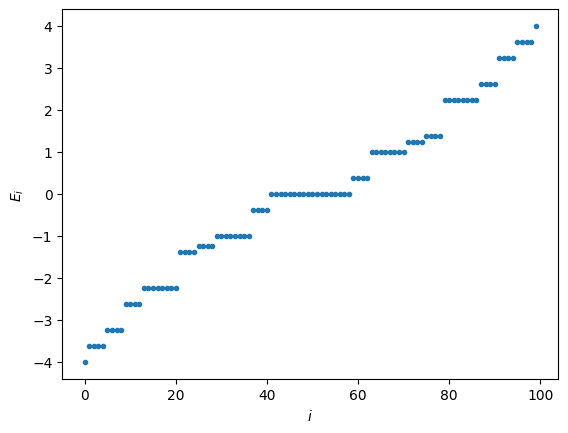

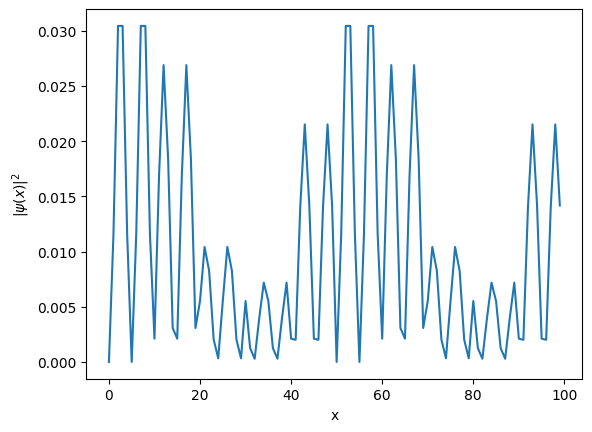

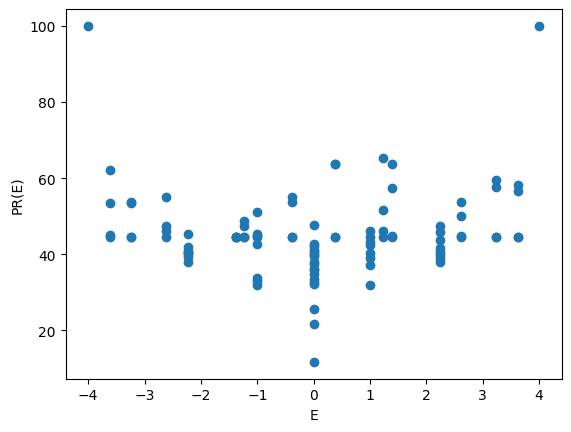

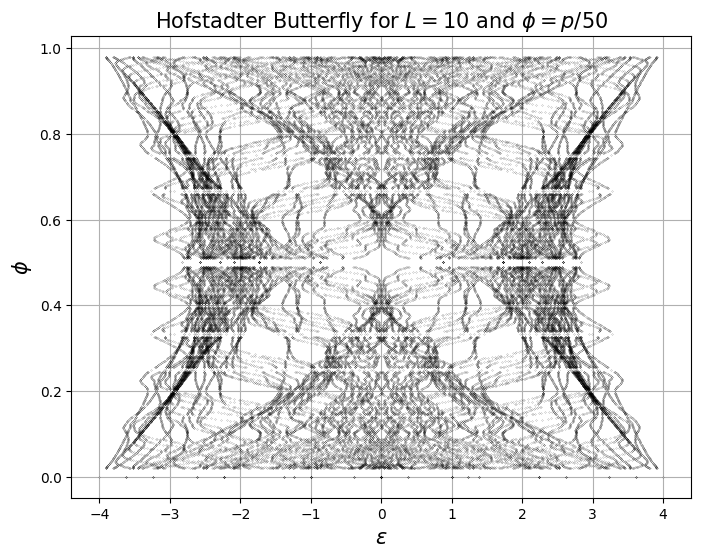

In [ ]:
# example 1 - (length=10 , t=1.0, disorder=0. , phi=0. , q=50)
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0. , phi= 0. , q = 50)
square.construct_matrix()
square.plot_evals()
print()
square.plot_evec()
print()
square.plot_pr()
print()
square.plot_butterfly()

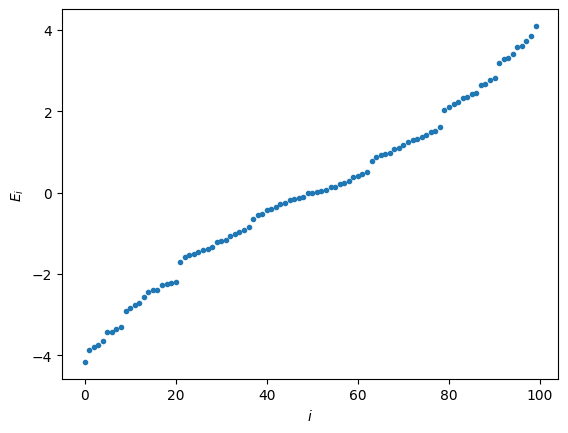

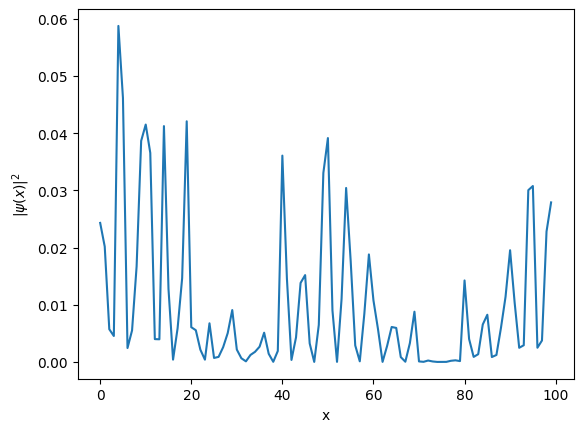

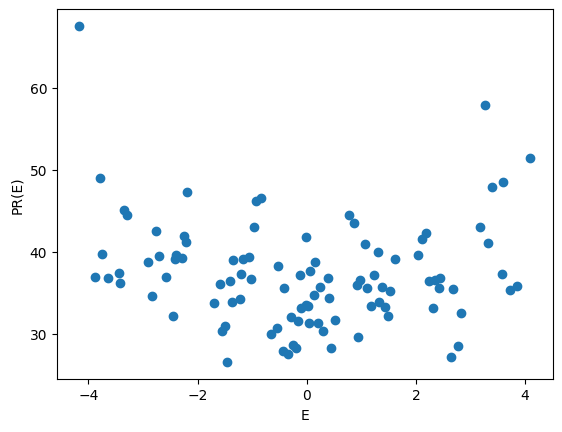

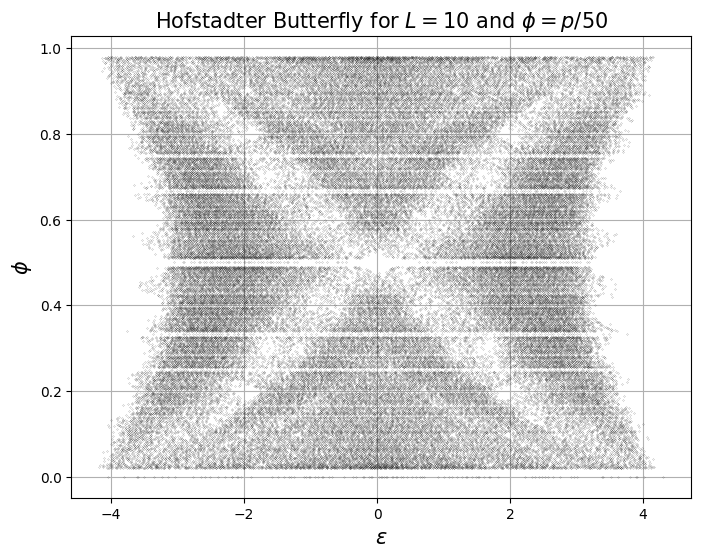

In [ ]:
# example 2 - (length=10 , t=1.0, disorder=0.5 , phi=0. , q=50)
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0.5 , phi= 0., q = 50)
square.construct_matrix()
square.plot_evals()
print()
square.plot_evec()
print()
square.plot_pr()
print()
square.plot_butterfly()

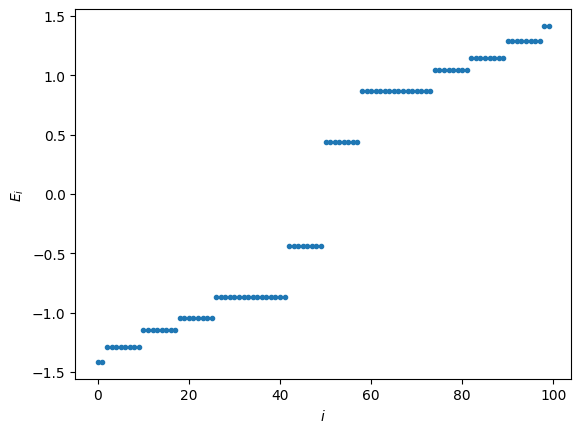

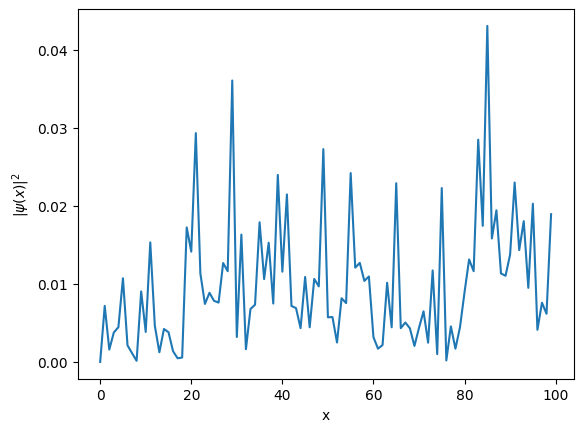

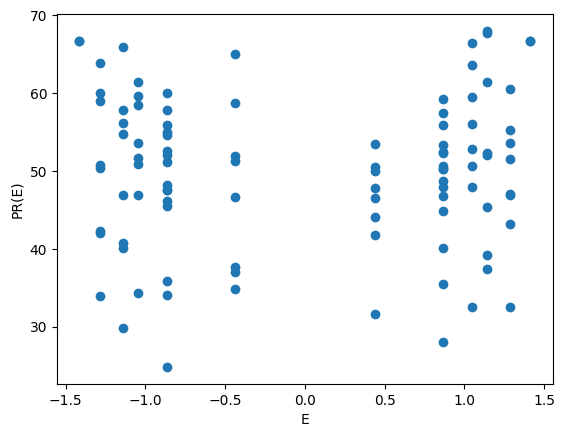

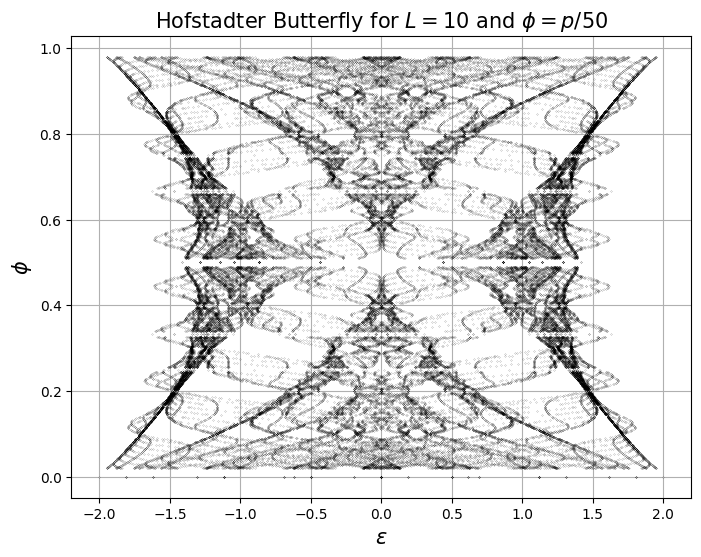

In [ ]:
# example 3 - (length=10 , t=1.0, disorder=0. , phi=0.5 , q=50)
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0. , phi= 0.5, q=50)
square.construct_matrix()
square.plot_evals()
print()
square.plot_evec()
print()
square.plot_pr()
print()
square.plot_butterfly()

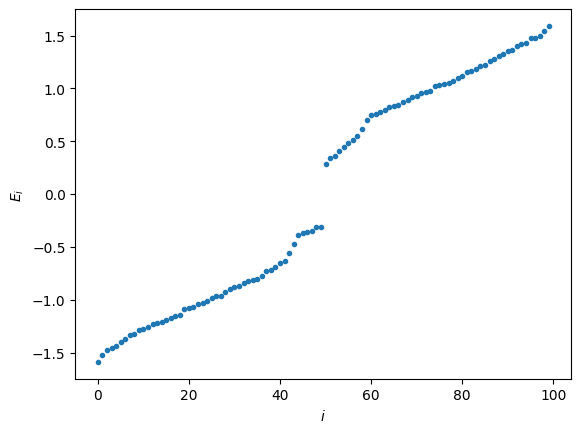

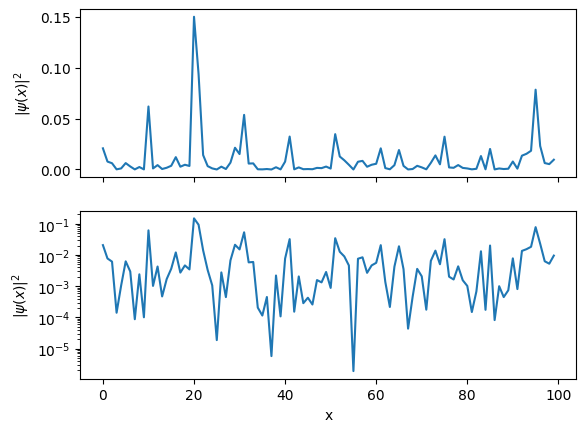

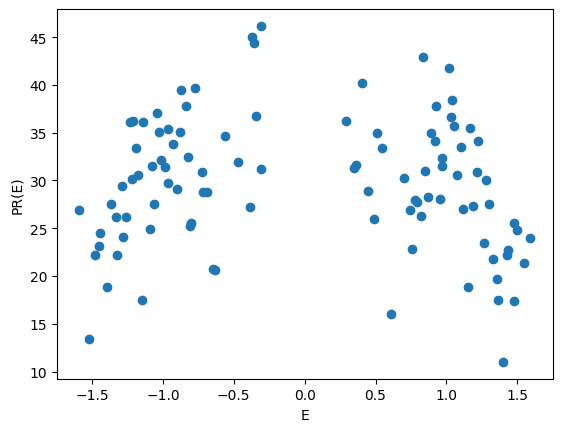

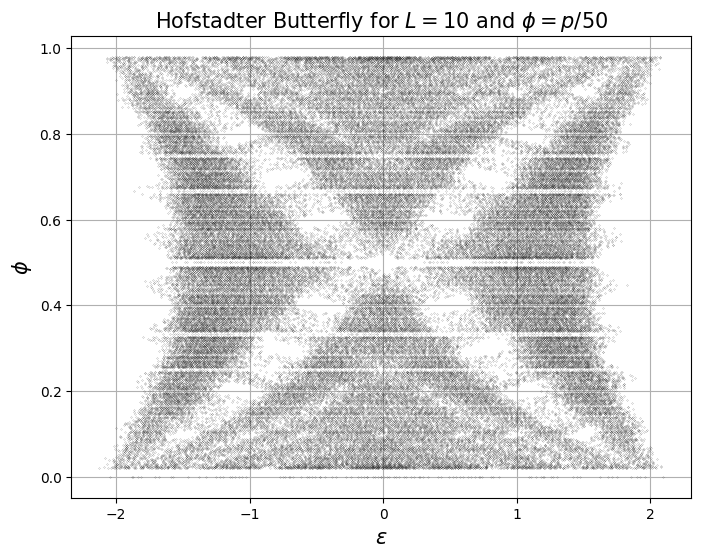

In [ ]:
# example 4 - (length=10 , t=1.0, disorder=0.5 , phi=0.5 , q=50)
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0.5 , phi=0.5, q=50)
square.construct_matrix()
square.plot_evals()
print()
square.plot_evec_disorder()
print()
square.plot_pr()
print()
square.plot_butterfly()

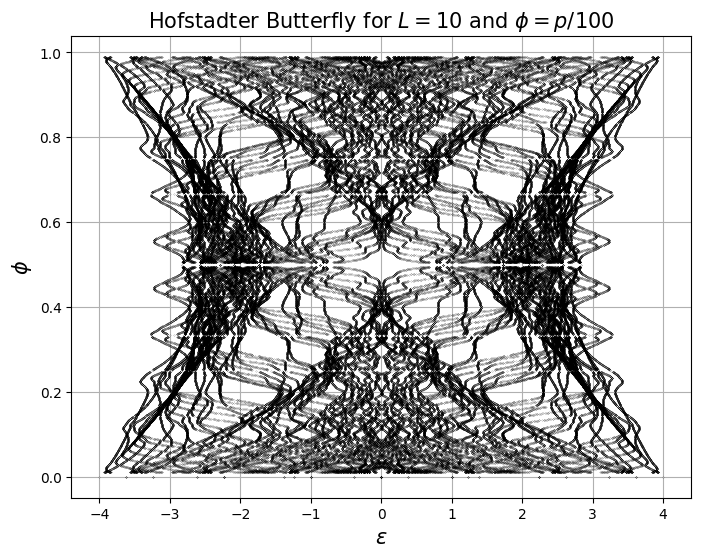

In [ ]:
# example 5 - (length=10 , t=1.0, disorder=0.0 , phi=0.0 , q=100)
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0.0, phi=0.0, q=100)
square.plot_butterfly()

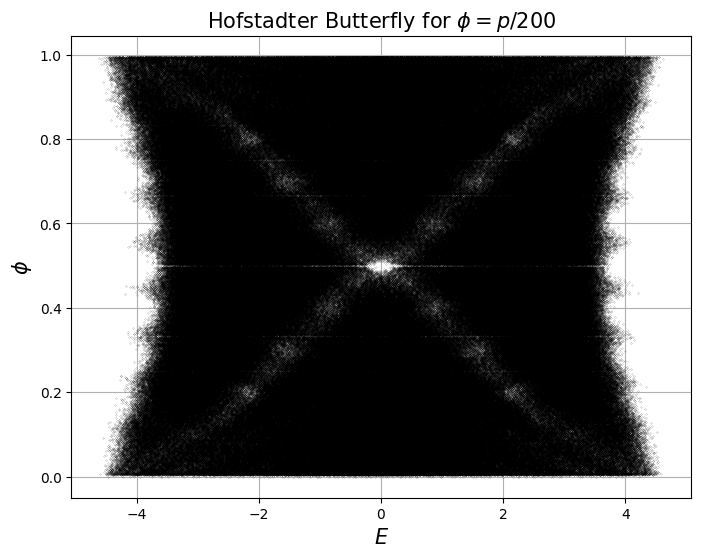

In [4]:
# example 6 - (length=10 , t=1.0, disorder=0.8 , phi=0.0 , q=200)
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0.8 , phi=0.0, q=200)
square.plot_butterfly()

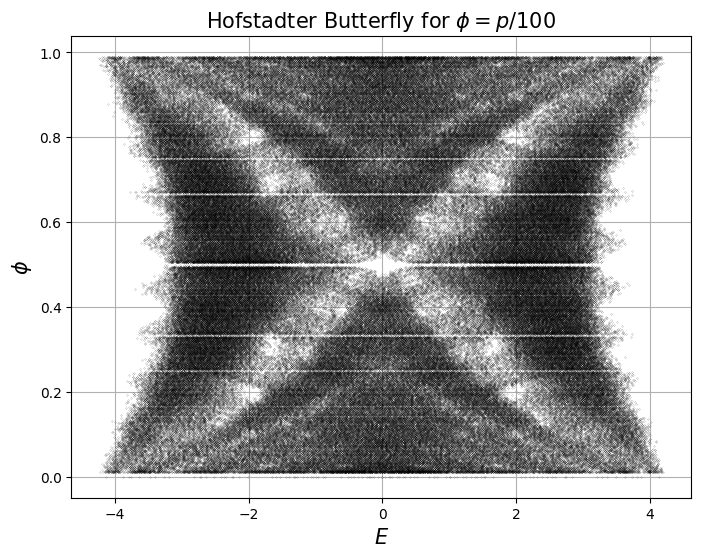

In [5]:
# example 7 - (length=10 , t=1.0, disorder=0.5 , phi=0.0 , q=100)
square = Square_Hamiltonian(length=10 , t=1.0, disorder=0.5 , phi=0.0, q=100)
square.plot_butterfly()